In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import kagglehub

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [ ]:
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")

print("Dataset path:", path)

# MRI ROOT PATH
mri_root = os.path.join(path, "Dataset", "Brain Tumor MRI images")

print("MRI root:", mri_root)

Using Colab cache for faster access to the 'brain-tumor-multimodal-image-ct-and-mri' dataset.
Dataset path: /kaggle/input/brain-tumor-multimodal-image-ct-and-mri
MRI root: /kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images


In [ ]:
classes = ["Healthy", "Tumor"]
image_paths = []
labels = []

for label, cls in enumerate(classes):
    folder = os.path.join(mri_root, cls)
    for f in os.listdir(folder):
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            image_paths.append(os.path.join(folder, f))
            labels.append(label)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("Total MRI images:", len(image_paths))
print("Class counts:", np.bincount(labels))

Total MRI images: 5000
Class counts: [2000 3000]


In [ ]:
IMAGE_SIZE = 224

def preprocess_mri(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)).astype(np.float32)

    # Normalize like ImageNet-compatible inputs
    img = (img - img.mean()) / (img.std() + 1e-6)
    img = np.stack([img, img, img], axis=0)  # keep float32
    return img

class MRIDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = preprocess_mri(self.paths[idx])  # (3,H,W)
        img = torch.tensor(img).float()        # convert to tensor
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label


In [ ]:
train_transform = None
val_transform = None

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 224 -> 112

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 112 -> 56

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 56 -> 28

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 28 -> 14

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)      # 14 -> 7
        )


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
def run_epoch(loader, train):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    preds_all, targs_all = [], []

    with torch.set_grad_enabled(train):
        for imgs, ys in loader:
            imgs, ys = imgs.to(device), ys.to(device)
            logits = model(imgs)
            loss = criterion(logits, ys)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            preds = torch.argmax(logits, dim=1)
            preds_all += preds.cpu().tolist()
            targs_all += ys.cpu().tolist()

            total_loss += loss.item() * imgs.size(0)

    acc = accuracy_score(targs_all, preds_all)
    f1  = f1_score(targs_all, preds_all, zero_division=1)
    loss = total_loss / len(loader.dataset)
    return loss, acc, f1

In [ ]:
fold_results = {
    "val_f1": [],
    "val_acc": []
}

best_overall_f1 = 0.0
best_overall_state = None

In [ ]:
image_paths = np.array(image_paths)
labels = np.array(labels)

EPOCHS = 12
criterion = nn.CrossEntropyLoss()

fold_id = 1

for train_idx, val_idx in kf.split(image_paths, labels):
    print(f"      Fold {fold_id} / 5      ")

    X_train, X_val = image_paths[train_idx], image_paths[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    train_ds = MRIDataset(X_train, y_train, transform=train_transform)
    val_ds   = MRIDataset(X_val, y_val, transform=val_transform)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

    # Init fresh model each fold
    model = SimpleCNN().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2)

    best_fold_f1 = 0.0
    best_fold_state = None

    for epoch in range(1, EPOCHS+1):
        tr_loss, tr_acc, tr_f1 = run_epoch(train_loader, train=True)
        val_loss, val_acc, val_f1 = run_epoch(val_loader, train=False)

        scheduler.step(val_f1)

        print(f"[Fold {fold_id}] Epoch {epoch:02d} | tr_f1={tr_f1:.3f} val_f1={val_f1:.3f}")

        if val_f1 > best_fold_f1:
            best_fold_f1 = val_f1
            best_fold_state = model.state_dict()

    fold_results["val_f1"].append(best_fold_f1)
    fold_results["val_acc"].append(val_acc)

    os.makedirs("cv_checkpoints", exist_ok=True)
    torch.save(best_fold_state, f"cv_checkpoints/simplecnn_fold{fold_id}_best.pt")

    print(f"Saved best fold model with F1={best_fold_f1:.4f}")

    if best_fold_f1 > best_overall_f1:
        best_overall_f1 = best_fold_f1
        best_overall_state = best_fold_state

    fold_id += 1

torch.save(best_overall_state, "best_cnn_model_5fold.pt")
print("Best Overall Model Saved")
print("best_cnn_model_5fold.pt")
print("Best F1:", best_overall_f1)

      Fold 1 / 5      
[Fold 1] Epoch 01 | tr_f1=0.799 val_f1=0.908
[Fold 1] Epoch 02 | tr_f1=0.934 val_f1=0.880
[Fold 1] Epoch 03 | tr_f1=0.948 val_f1=0.910
[Fold 1] Epoch 04 | tr_f1=0.963 val_f1=0.903
[Fold 1] Epoch 05 | tr_f1=0.967 val_f1=0.971
[Fold 1] Epoch 06 | tr_f1=0.977 val_f1=0.957
[Fold 1] Epoch 07 | tr_f1=0.985 val_f1=0.975
[Fold 1] Epoch 08 | tr_f1=0.977 val_f1=0.974
[Fold 1] Epoch 09 | tr_f1=0.989 val_f1=0.962
[Fold 1] Epoch 10 | tr_f1=0.987 val_f1=0.975
[Fold 1] Epoch 11 | tr_f1=0.996 val_f1=0.983
[Fold 1] Epoch 12 | tr_f1=0.997 val_f1=0.987
Saved best fold model with F1=0.9875
      Fold 2 / 5      
[Fold 2] Epoch 01 | tr_f1=0.835 val_f1=0.755
[Fold 2] Epoch 02 | tr_f1=0.935 val_f1=0.948
[Fold 2] Epoch 03 | tr_f1=0.958 val_f1=0.941
[Fold 2] Epoch 04 | tr_f1=0.966 val_f1=0.425
[Fold 2] Epoch 05 | tr_f1=0.967 val_f1=0.970
[Fold 2] Epoch 06 | tr_f1=0.980 val_f1=0.958
[Fold 2] Epoch 07 | tr_f1=0.983 val_f1=0.973
[Fold 2] Epoch 08 | tr_f1=0.984 val_f1=0.949
[Fold 2] Epoch 09

In [ ]:
best_model = SimpleCNN().to(device)
best_model.load_state_dict(torch.load("best_cnn_model_5fold.pt"))
best_model.eval()
print("Loaded best model.")

Loaded best model.


In [ ]:
def find_last_conv(model):
    for layer in reversed(model.features):
        if isinstance(layer, nn.Conv2d):
            return layer
    raise ValueError("No Conv2d layer found")


class UniversalCAM:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.target_layer = find_last_conv(model)

        self.activations = None
        self.gradients = None

        # Use ONLY regular hooks → avoids conflicts
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, inp, out):
        # Save activations on GPU
        self.activations = out.detach().to(device)

    def save_gradient(self, module, grad_in, grad_out):
        # Save gradients on GPU
        self.gradients = grad_out[0].detach().to(device)

    def generate(self, x):
        # Forward pass
        out = self.model(x)
        class_idx = torch.argmax(out)

        # Backward pass
        self.model.zero_grad()
        out[0, class_idx].backward()

        # Extract stored data
        acts = self.activations[0]   # (C,H,W)
        grads = self.gradients[0]    # (C,H,W)

        # Weight each channel by average gradient
        weights = grads.mean(dim=(1,2))

        cam = torch.zeros(acts.shape[1:], dtype=torch.float32, device=device)
        for c, w in enumerate(weights):
            cam += w * acts[c]

        cam = F.relu(cam)
        cam = cam / (cam.max() + 1e-6)

        return cam.detach().cpu().numpy()


In [ ]:
def generate_cam_image(path, cam_obj):
    tensor = torch.tensor(preprocess_mri(path)).unsqueeze(0).float().to(device)

    cam_map = cam_obj.generate(tensor)
    cam_map = cv2.resize(cam_map, (224,224))

    raw = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    raw = cv2.resize(raw, (224,224))
    raw_rgb = cv2.cvtColor(raw, cv2.COLOR_GRAY2RGB)

    heat = cv2.applyColorMap((cam_map*255).astype(np.uint8), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(raw_rgb, 0.4, heat, 0.6, 0)
    return raw_rgb, heat, overlay


In [ ]:
def generate_cam_image(path, cam_obj):
    tensor = torch.tensor(preprocess_mri(path)).unsqueeze(0).float().to(device)

    cam_map = cam_obj.generate(tensor)
    cam_map = cv2.resize(cam_map, (224,224))

    raw = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    raw = cv2.resize(raw, (224,224))
    raw_rgb = cv2.cvtColor(raw, cv2.COLOR_GRAY2RGB)

    heat = cv2.applyColorMap((cam_map*255).astype(np.uint8), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(raw_rgb, 0.4, heat, 0.6, 0)
    return raw_rgb, heat, overlay

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


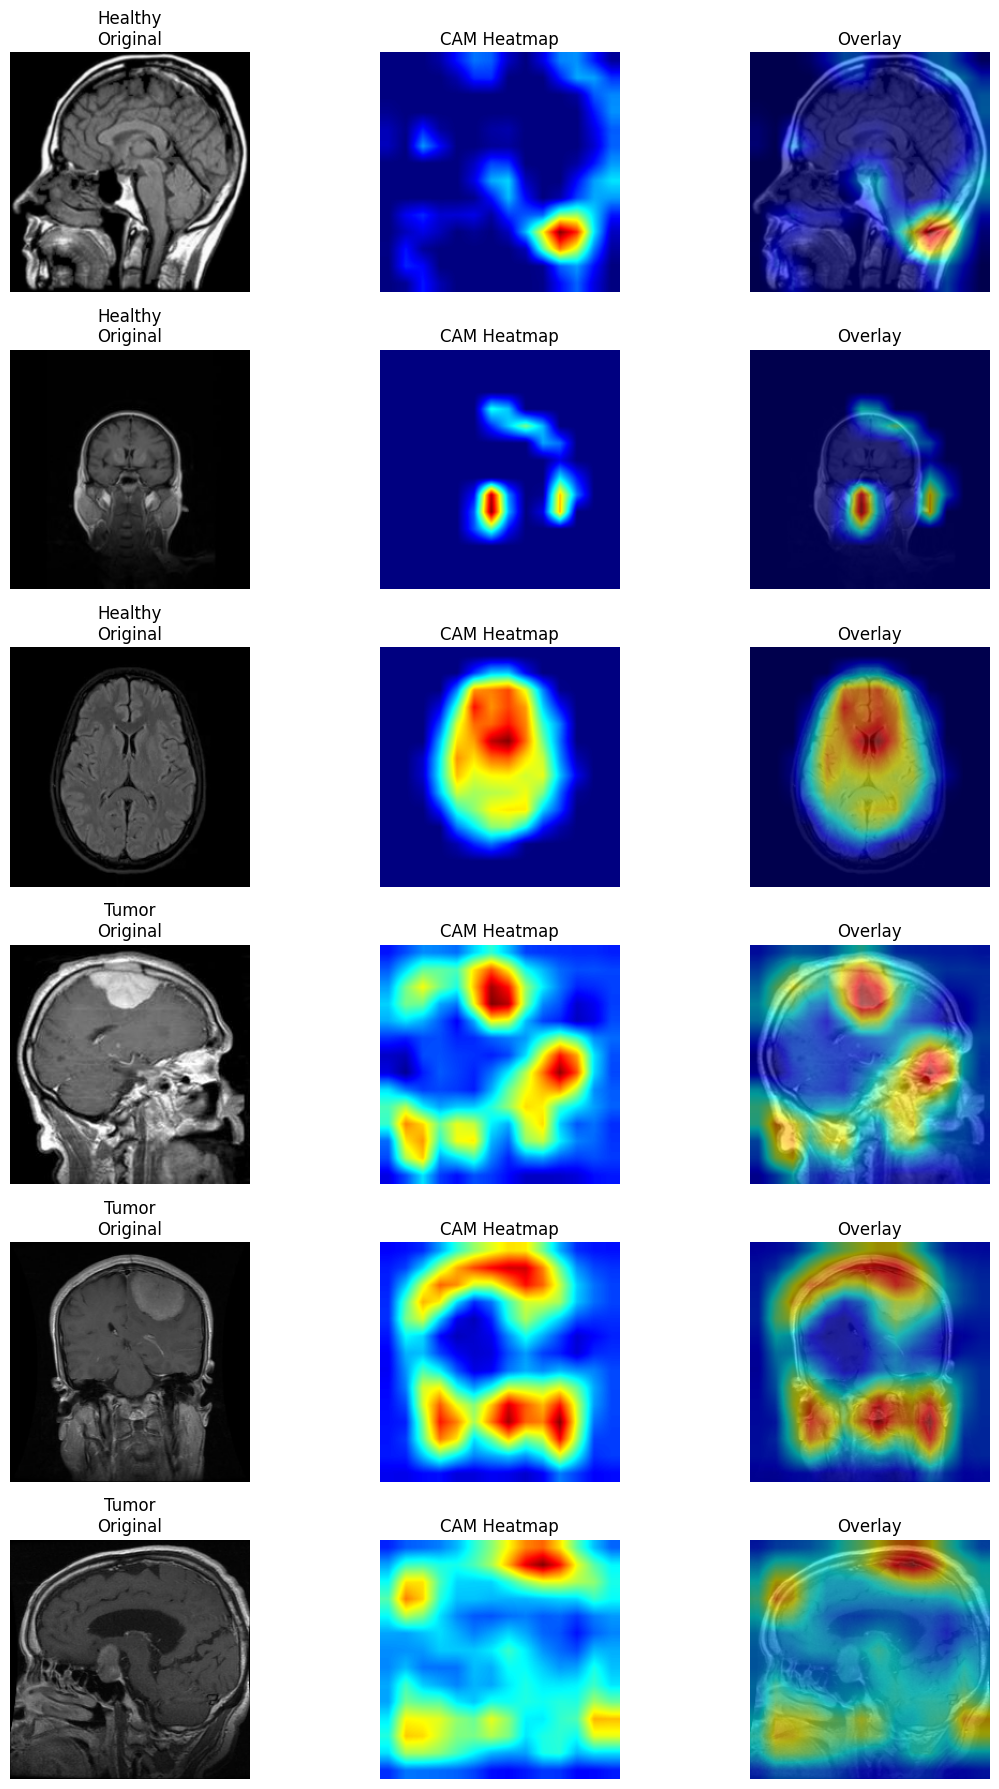

In [ ]:
healthy_paths = image_paths[labels==0][:3]
tumor_paths   = image_paths[labels==1][:3]

paths = list(healthy_paths) + list(tumor_paths)

cam_obj = UniversalCAM(best_model)

plt.figure(figsize=(12,18))
rows = len(paths)

for i, p in enumerate(paths):
    raw, heat, overlay = generate_cam_image(p, cam_obj)

    title = "Healthy" if i < 3 else "Tumor"

    plt.subplot(rows,3,3*i+1); plt.imshow(raw); plt.title(title+"\nOriginal"); plt.axis("off")
    plt.subplot(rows,3,3*i+2); plt.imshow(heat); plt.title("CAM Heatmap"); plt.axis("off")
    plt.subplot(rows,3,3*i+3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
def cam_focus_score(cam_map, threshold=0.6):
    """
    Measures how 'focused' the Grad-CAM is.
    Higher score = more activation concentrated in smaller region = better.
    """
    cam_norm = (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min() + 1e-6)
    high_act = cam_norm > threshold
    return high_act.sum() / cam_norm.size

In [ ]:
cam_obj = UniversalCAM(best_model)

cam_scores = []
model_probs = []
true_labels = []

for p, y in zip(image_paths, labels):
    x = torch.tensor(preprocess_mri(p)).unsqueeze(0).float().to(device)

    # model probability of tumor
    logits = best_model(x)
    prob = F.softmax(logits, dim=1)[0][1].item()

    # CAM map
    cam_map = cam_obj.generate(x)
    score = cam_focus_score(cam_map)

    cam_scores.append(score)
    model_probs.append(prob)
    true_labels.append(y)

cam_scores = np.array(cam_scores)
model_probs = np.array(model_probs)
true_labels = np.array(true_labels)

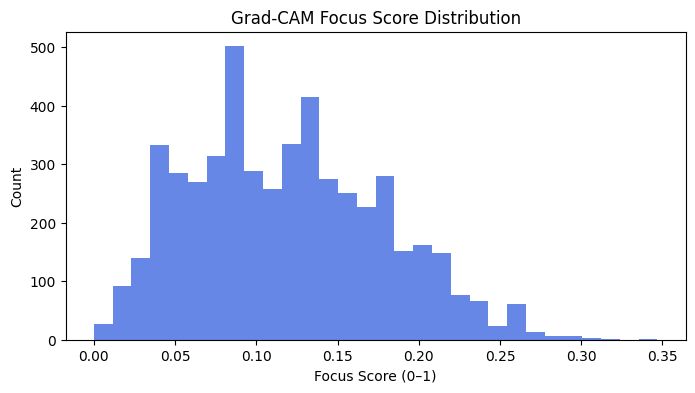

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(cam_scores, bins=30, color="royalblue", alpha=0.8)
plt.title("Grad-CAM Focus Score Distribution")
plt.xlabel("Focus Score (0–1)")
plt.ylabel("Count")
plt.show()

/tmp/ipython-input-3085871538.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([healthy_scores, tumor_scores], labels=["Healthy", "Tumor"])


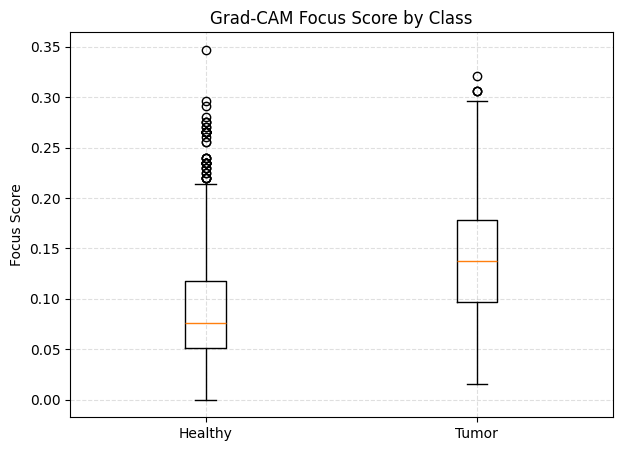

In [ ]:
healthy_scores = cam_scores[true_labels == 0]
tumor_scores = cam_scores[true_labels == 1]

plt.figure(figsize=(7,5))
plt.boxplot([healthy_scores, tumor_scores], labels=["Healthy", "Tumor"])
plt.title("Grad-CAM Focus Score by Class")
plt.ylabel("Focus Score")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

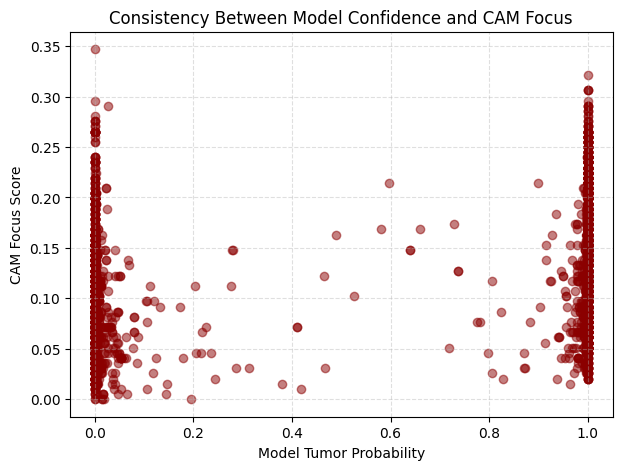

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(model_probs, cam_scores, alpha=0.5, color="darkred")
plt.xlabel("Model Tumor Probability")
plt.ylabel("CAM Focus Score")
plt.title("Consistency Between Model Confidence and CAM Focus")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [ ]:
print("=== GRAD-CAM SUMMARY ===")
print(f"Mean CAM Score (ALL): {cam_scores.mean():.4f}")
print(f"Mean CAM Score (Healthy): {healthy_scores.mean():.4f}")
print(f"Mean CAM Score (Tumor): {tumor_scores.mean():.4f}")
print("\nCorrelation between Confidence & CAM Focus:")
print(np.corrcoef(model_probs, cam_scores)[0,1])

=== GRAD-CAM SUMMARY ===
Mean CAM Score (ALL): 0.1186
Mean CAM Score (Healthy): 0.0871
Mean CAM Score (Tumor): 0.1396

Correlation between Confidence & CAM Focus:
0.4410896573349248
